In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as scipy
sys.path.append("..\\backtesting")
import dynamic_backtesting as db
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 


In [2]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())

**Henter return data udfra tickers**

In [3]:
return_data =db.download_return_data(tickers, save_to_csv=True)

[*********************100%***********************]  11 of 11 completed


**Simulere Non central t-fordelinger til $r_t$. Bemærk at disse ikke er dem fra MGARCH modellen**

In [4]:
#fitter NCT fordeling til return data
t_dist= return_data.apply(scipy.nct.fit, axis=0) 
stat = pd.DataFrame([t_dist.iloc[0],t_dist.iloc[1],t_dist.iloc[2],t_dist.iloc[3]], columns = tickers, index = ['DF','NC','LOC','SCALE']).transpose()

#Sætter længde af simuleringen og random state
T=len(return_data)
state=2016

#Simulere data og ligger det i et dataframe
for index,row in stat.iterrows():
    simulated_returns_1=scipy.nct.rvs(row['DF'],row['NC'],loc=row['LOC'],scale=row['SCALE'],size=T,random_state=state)
    if index=="EEM":
        simulated_returns=pd.DataFrame(simulated_returns_1, columns = ["EEM"])
    else:
        simulated_returns[index]=simulated_returns_1

**Laver funktioner MGARCH model fit og udregning af vægte**

In [5]:
def GARCH_MODEL(ugarch_model="sGARCH", garch_order=(1, 1)):
    """
    Estimate af GARCH model and parse parameters, sigmas and residuals
    ugarch_model: sGARCH, gjrGARCH
    garch_order: (1, 1), (1,0)
    """
    coef, residuals, sigmas = db.fit_garch_model()
    return coef, residuals, sigmas

In [6]:
def Simulation_maker(GARCHTYPE,Data, coef, residuals, sigmas):
    """
    Makes data for an simulations with a GARCH type model using the data in the csv file and simulation

    Variables:
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Data: Data used to find Omega_t to the simulated data
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, 11, GARCHTYPE)
    #udregner omega
    sim_omega_s=db.calc_Omega_ts(Data,sigmas,residuals, **params_dict)
    #udregner vægte
    sim_weights=db.calc_weights_garch_no_trading_cost(sim_omega_s)
    return sim_weights

**ARCH(1)**

In [7]:
coef_ARCH, residuals_ARCH, sigmas_ARCH= GARCH_MODEL("sGARCH",(1,0))

In [9]:
sim_weights_ARCH=Simulation_maker("sGARCH10",simulated_returns,coef_ARCH, residuals_ARCH, sigmas_ARCH)

ValueError: cannot reshape array of size 55 into shape (11,4)

**GARCH(1,1)**

In [ ]:
coef_GARCH, residuals_GARCH, sigmas_GARCH= GARCH_MODEL("sGARCH",(1,1))

In [ ]:
sim_weights_GARCH=Simulation_maker("sGARCH11",simulated_returns,coef_GARCH, residuals_GARCH, sigmas_GARCH)

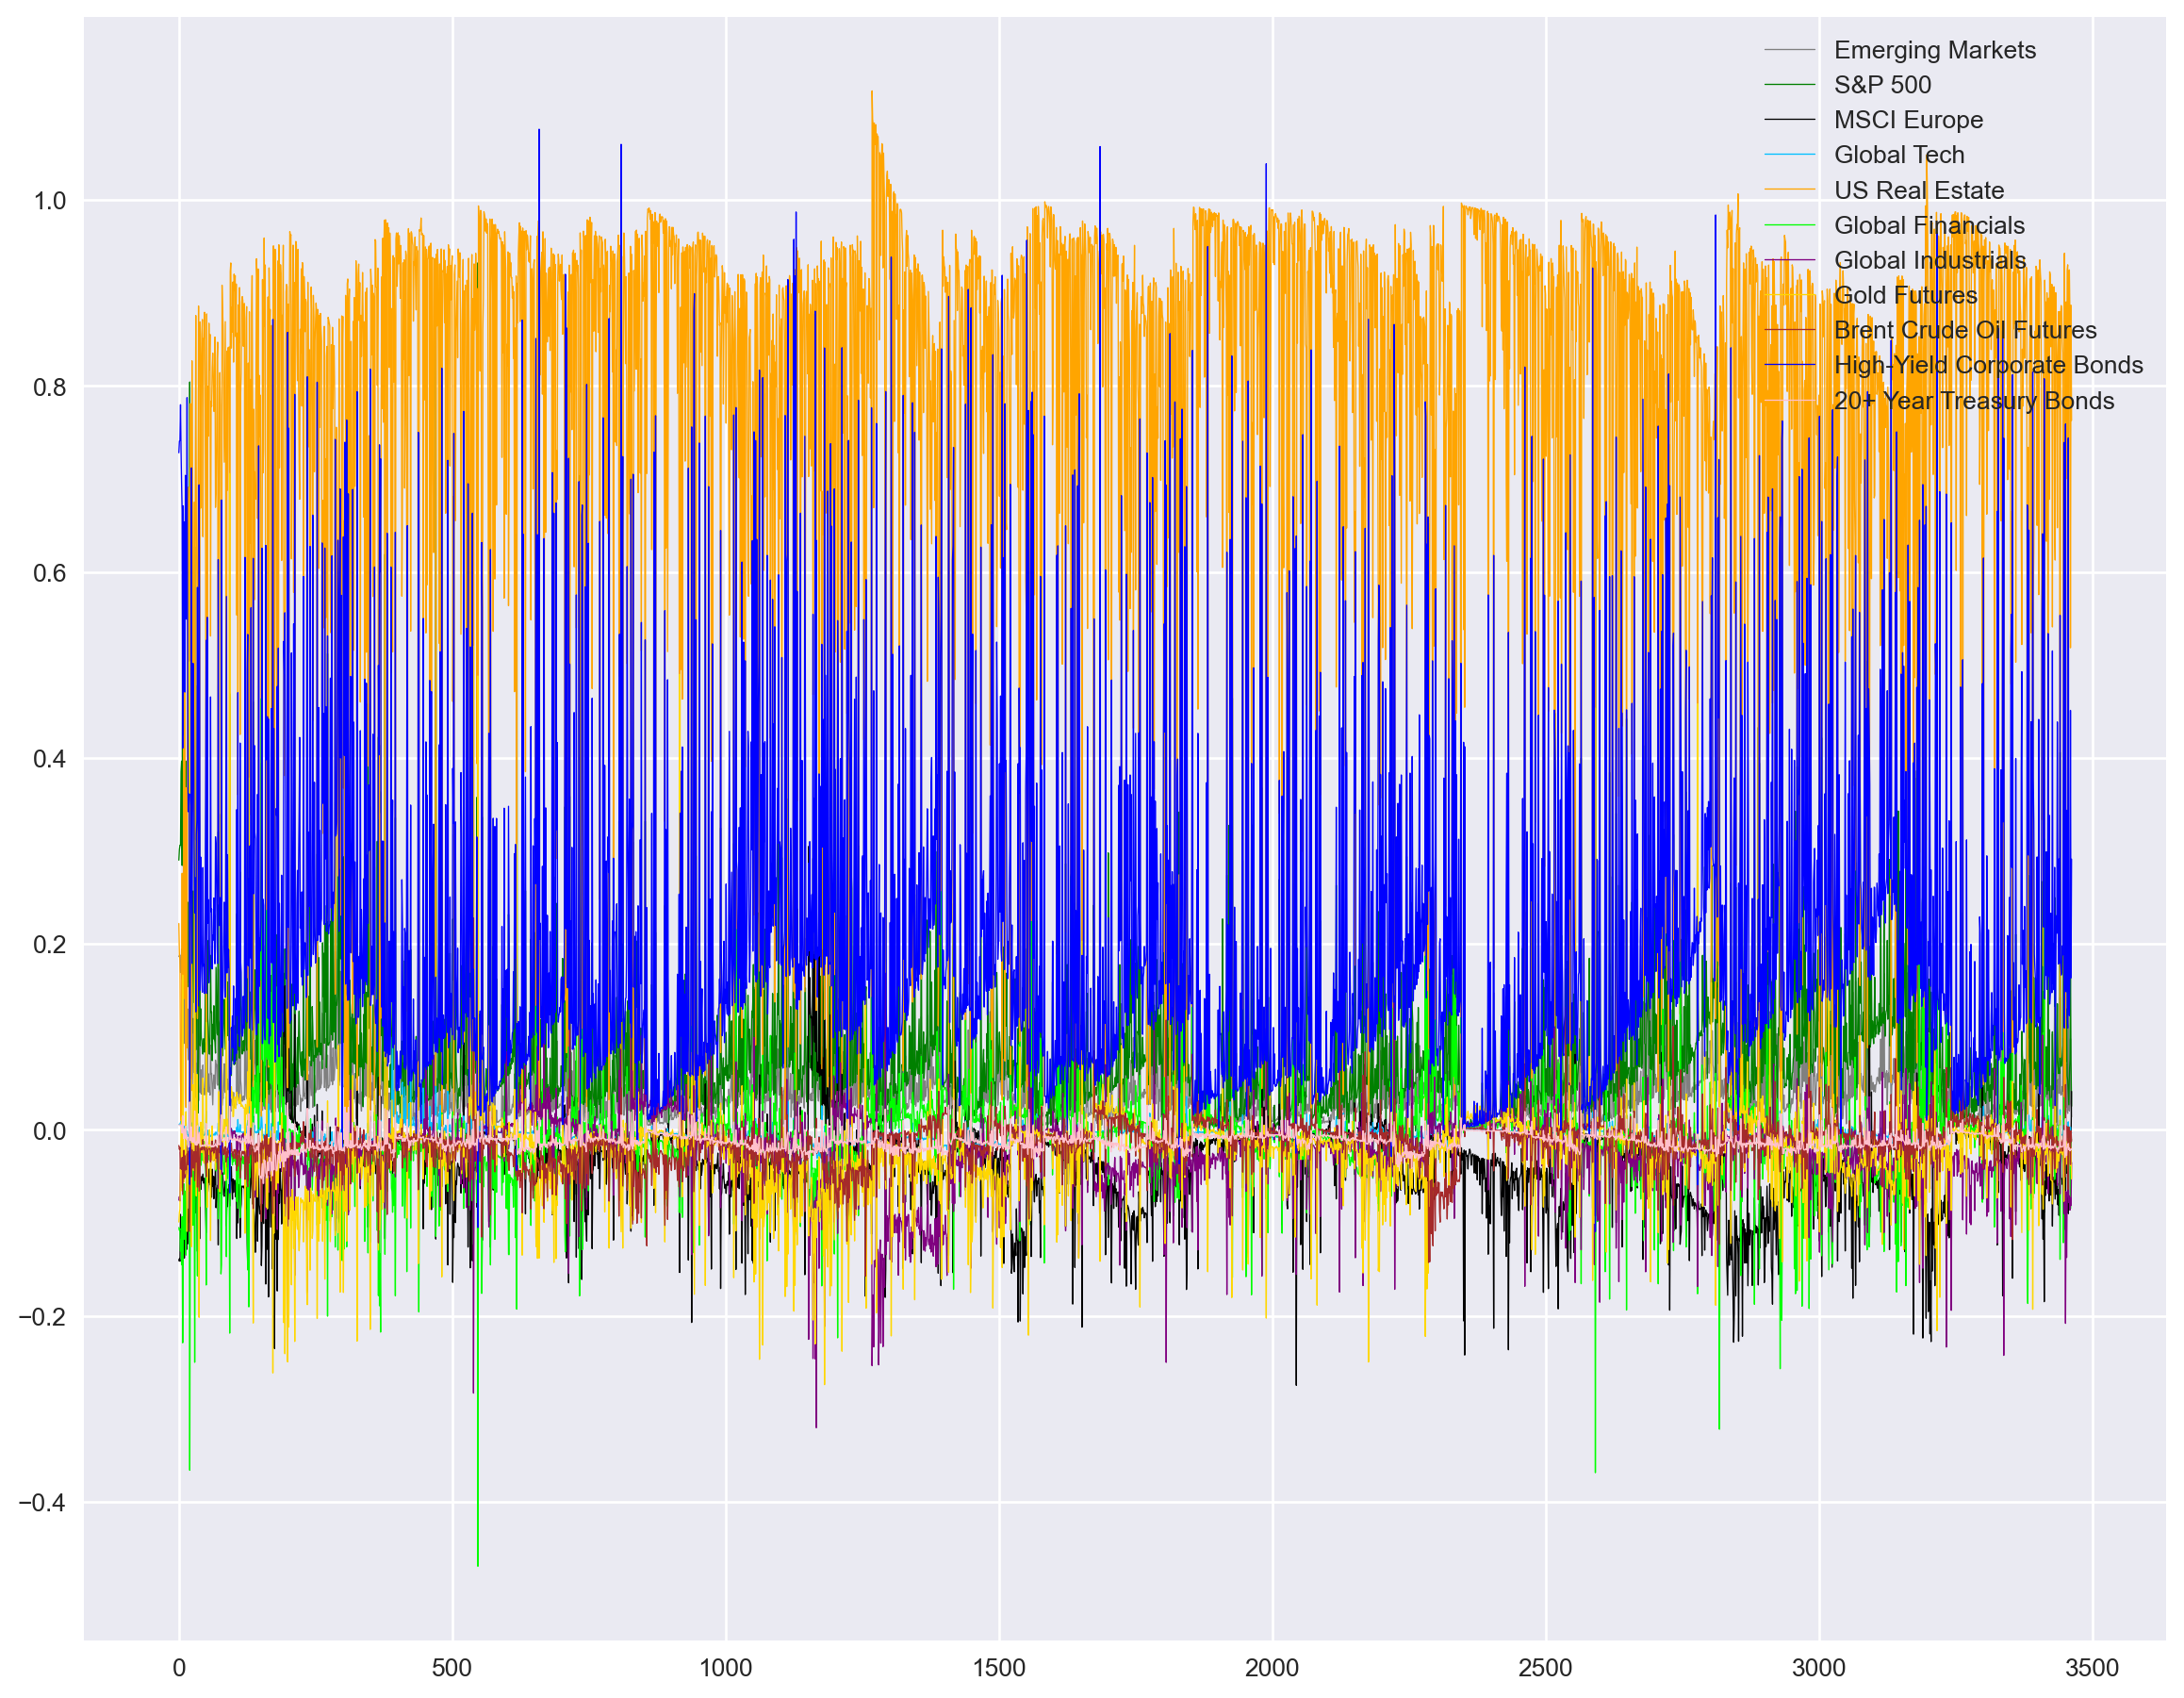

In [ ]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(15,12), dpi=190)
ax.plot(sim_weights_GARCH,linewidth=0.5)
ax.legend(asset_names, loc='upper right')
#ax.set_xlabel('Returns') 
#ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 

**GJR-GARCH(1,1)**

In [ ]:
coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH= GARCH_MODEL("gjrGARCH",(1,1))

In [ ]:
sim_weights_GJRGARCH=Simulation_maker("gjrGARCH11",simulated_returns,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH)

**sammenligner 1/N portfølge**